In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

In [2]:
!wandb disabled

W&B disabled.


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 52.6 MB/s eta 0:00:00


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.applications import DenseNet121
from keras import backend as keras
from ultralytics import YOLO
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
!unzip dataset.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: dataset/train/images/image1_77_png.rf.2f23e0ccdc7354f212cb0645bf72526b.jpg  
  inflating: dataset/train/images/image1_77_png.rf.40aa79c7cf49388b0c85a7fea44ecac0.jpg  
  inflating: dataset/train/images/image1_77_png.rf.737788e8914549c99d6625dd53947649.jpg  
  inflating: dataset/train/images/image1_77_png.rf.77f753e3e371ffba460e810d7ef17922.jpg  
  inflating: dataset/train/images/image1_77_png.rf.ffc78fd2dd54a787faf573ae7446593a.jpg  
  inflating: dataset/train/images/image1_7817_png.rf.960faf235342d59143645fc760e6442b.jpg  
  inflating: dataset/train/images/image1_7817_png.rf.bc14d80bef93d856ea1e7de31fe77c85.jpg  
  inflating: dataset/train/images/image1_7817_png.rf.c068ac7683b97e14e924a756c9d269e7.jpg  
  inflating: dataset/train/images/image1_782_png.rf.0c2a77d730675bba0c25a6819919e769.jpg  
  inflating: dataset/train/images/image1_782_png.rf.55fd7afbb62059260d8fca61357bde4c.jpg  
  inflating: dataset/train/images/image1_7

In [6]:
pwd

'/content'

In [7]:
train_images = '/content/dataset/train/images'
train_labels = '/content/dataset/train/labels'

test_images = '/content/dataset/test/images'
test_labels = '/content/dataset/test/images'

val_images = '/content/dataset/valid/images'
val_labels = '/content/dataset/valid/labels'

In [8]:
print('Number of train frames: ' + str(len(os.listdir(train_images))))
print('Number of train labels: ' + str(len(os.listdir(train_labels))))
print('Number of val frames: ' + str(len(os.listdir(val_images))))
print('Number of val labels: ' + str(len(os.listdir(val_labels))))
print('Number of test frames: ' + str(len(os.listdir(test_images))))
print('Number of test labels: ' + str(len(os.listdir(test_labels))))
print('Total frames: ' + str(len(os.listdir(train_images)) + len(os.listdir(test_images)) + len(os.listdir(val_images))))

Number of train frames: 3631
Number of train labels: 3631
Number of val frames: 348
Number of val labels: 348
Number of test frames: 169
Number of test labels: 169
Total frames: 4148


In [9]:

# Percorsi
images_folder = "dataset/train/images"
labels_folder = "dataset/train/labels"
output_folder_labes = "dataset/train2/labels"
output_folder_images = "dataset/train2/images"

# Crea la cartella di output se non esiste
os.makedirs(output_folder_labes, exist_ok=True)
os.makedirs(output_folder_images, exist_ok=True)

# Funzione per aggiornare le coordinate delle label dopo rotazioni
def rotate_bboxes(bboxes, rotation):
    rotated_bboxes = []
    for bbox in bboxes:
        id_class = bbox[0]
        points = bbox[1:]
        rotated_points = []
        for i in range(0, len(points), 2):  # Processa i punti x, y
            x = points[i]
            y = points[i + 1]
            if rotation == 90:
                x_new = y
                y_new = 1 - x
            elif rotation == 180:
                x_new = 1 - x
                y_new = 1 - y
            elif rotation == 270:
                x_new = 1 - y
                y_new = x
            else:
                raise ValueError("Rotazione non supportata")
            rotated_points.extend([x_new, y_new])
        rotated_bboxes.append([id_class] + rotated_points)
    return rotated_bboxes

# Leggi tutti i file di label
for label_file in os.listdir(labels_folder):
    if label_file.endswith(".txt"):
        label_path = os.path.join(labels_folder, label_file)

        # Trova il corrispondente file immagine
        image_name = label_file.replace(".txt", ".jpg")  # Assumendo che le immagini siano .jpg
        image_path = os.path.join(images_folder, image_name)

        if not os.path.exists(image_path):
            print(f"Immagine mancante per: {label_file}, salto.")
            continue

        # Copia i file originali nella cartella di output
        new_image_path = os.path.join(output_folder_images, image_name)
        new_label_path = os.path.join(output_folder_labes, label_file)
        cv2.imwrite(new_image_path, cv2.imread(image_path))
        with open(new_label_path, "w") as file:
            if os.path.getsize(label_path) > 0:
                with open(label_path, "r") as original_label:
                    file.write(original_label.read())
        print(f"Copiati file originali: {image_name}, {label_file}")

        # Se il file di label è vuoto, salta le rotazioni
        if os.path.getsize(label_path) == 0:
            print(f"File vuoto: {label_file}, nessuna rotazione eseguita.")
            continue

        # Carica l'immagine
        image = cv2.imread(image_path)
        if image is None:
            print(f"Impossibile caricare l'immagine: {image_name}, salto.")
            continue

        # Leggi e parsifica le label
        bboxes = []
        with open(label_path, "r") as file:
            for line in file:
                values = list(map(float, line.strip().split()))
                id_class = int(values[0])
                points = values[1:]
                bboxes.append([id_class] + points)

        # Copia i file originali nella cartella di output
        new_image_path = os.path.join(output_folder_images, image_name)
        new_label_path = os.path.join(output_folder_labes, label_file)
        cv2.imwrite(new_image_path, image)
        with open(new_label_path, "w") as file:
            for bbox in bboxes:
                bbox_line = " ".join(map(str, [bbox[0]] + bbox[1:]))
                file.write(bbox_line + "\n")
        print(f"Copiati file originali: {image_name}, {label_file}")

        # Rotazioni da eseguire
        rotations = [180]  # Aggiungi 90 270
        for rotation in rotations:
            # Ruota l'immagine
            if rotation == 90:
                rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
            elif rotation == 180:
                rotated_image = cv2.rotate(image, cv2.ROTATE_180)
            elif rotation == 270:
                rotated_image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            else:
                raise ValueError("Rotazione non supportata")

            # Aggiorna le coordinate delle label
            rotated_bboxes = rotate_bboxes(bboxes, rotation)

            # Nome per il nuovo file immagine e txt
            new_image_name = f"rotated_{rotation}_{image_name}"
            new_image_path = os.path.join(output_folder_images, new_image_name)
            new_label_name = f"rotated_{rotation}_{label_file}"
            new_label_path = os.path.join(output_folder_labes, new_label_name)

            # Salva la nuova immagine
            cv2.imwrite(new_image_path, rotated_image)

            # Salva le nuove label
            with open(new_label_path, "w") as file:
                for bbox in rotated_bboxes:
                    bbox_line = " ".join(map(str, [bbox[0]] + bbox[1:]))
                    file.write(bbox_line + "\n")

            print(f"Creati: {new_image_name}, {new_label_name}")


Output streaming troncato alle ultime 5000 righe.
File vuoto: image1_640_png.rf.8ba9be52ab6128b893e1e559ca6ecb1b.txt, nessuna rotazione eseguita.
Copiati file originali: image1_231_png.rf.ae803bd6f1a6643a47aa978526380a47.jpg, image1_231_png.rf.ae803bd6f1a6643a47aa978526380a47.txt
File vuoto: image1_231_png.rf.ae803bd6f1a6643a47aa978526380a47.txt, nessuna rotazione eseguita.
Copiati file originali: image1_31_png.rf.46aa186f3bd514bdc1499901518acc92.jpg, image1_31_png.rf.46aa186f3bd514bdc1499901518acc92.txt
File vuoto: image1_31_png.rf.46aa186f3bd514bdc1499901518acc92.txt, nessuna rotazione eseguita.
Copiati file originali: image1_1964_png.rf.1f80ff9665341f4fc0ba0e006085893f.jpg, image1_1964_png.rf.1f80ff9665341f4fc0ba0e006085893f.txt
Copiati file originali: image1_1964_png.rf.1f80ff9665341f4fc0ba0e006085893f.jpg, image1_1964_png.rf.1f80ff9665341f4fc0ba0e006085893f.txt
Creati: rotated_180_image1_1964_png.rf.1f80ff9665341f4fc0ba0e006085893f.jpg, rotated_180_image1_1964_png.rf.1f80ff9665341

In [10]:
train_images = '/content/dataset/train2/images'
train_labels = '/content/dataset/train2/labels'

test_images = '/content/dataset/test/images'
test_labels = '/content/dataset/test/images'

val_images = '/content/dataset/valid/images'
val_labels = '/content/dataset/valid/labels'

In [11]:
print('Number of train frames: ' + str(len(os.listdir(train_images))))
print('Number of train labels: ' + str(len(os.listdir(train_labels))))
print('Number of val frames: ' + str(len(os.listdir(val_images))))
print('Number of val labels: ' + str(len(os.listdir(val_labels))))
print('Number of test frames: ' + str(len(os.listdir(test_images))))
print('Number of test labels: ' + str(len(os.listdir(test_labels))))
print('Total frames: ' + str(len(os.listdir(train_images)) + len(os.listdir(test_images)) + len(os.listdir(val_images))))

Number of train frames: 5435
Number of train labels: 5435
Number of val frames: 348
Number of val labels: 348
Number of test frames: 169
Number of test labels: 169
Total frames: 5952


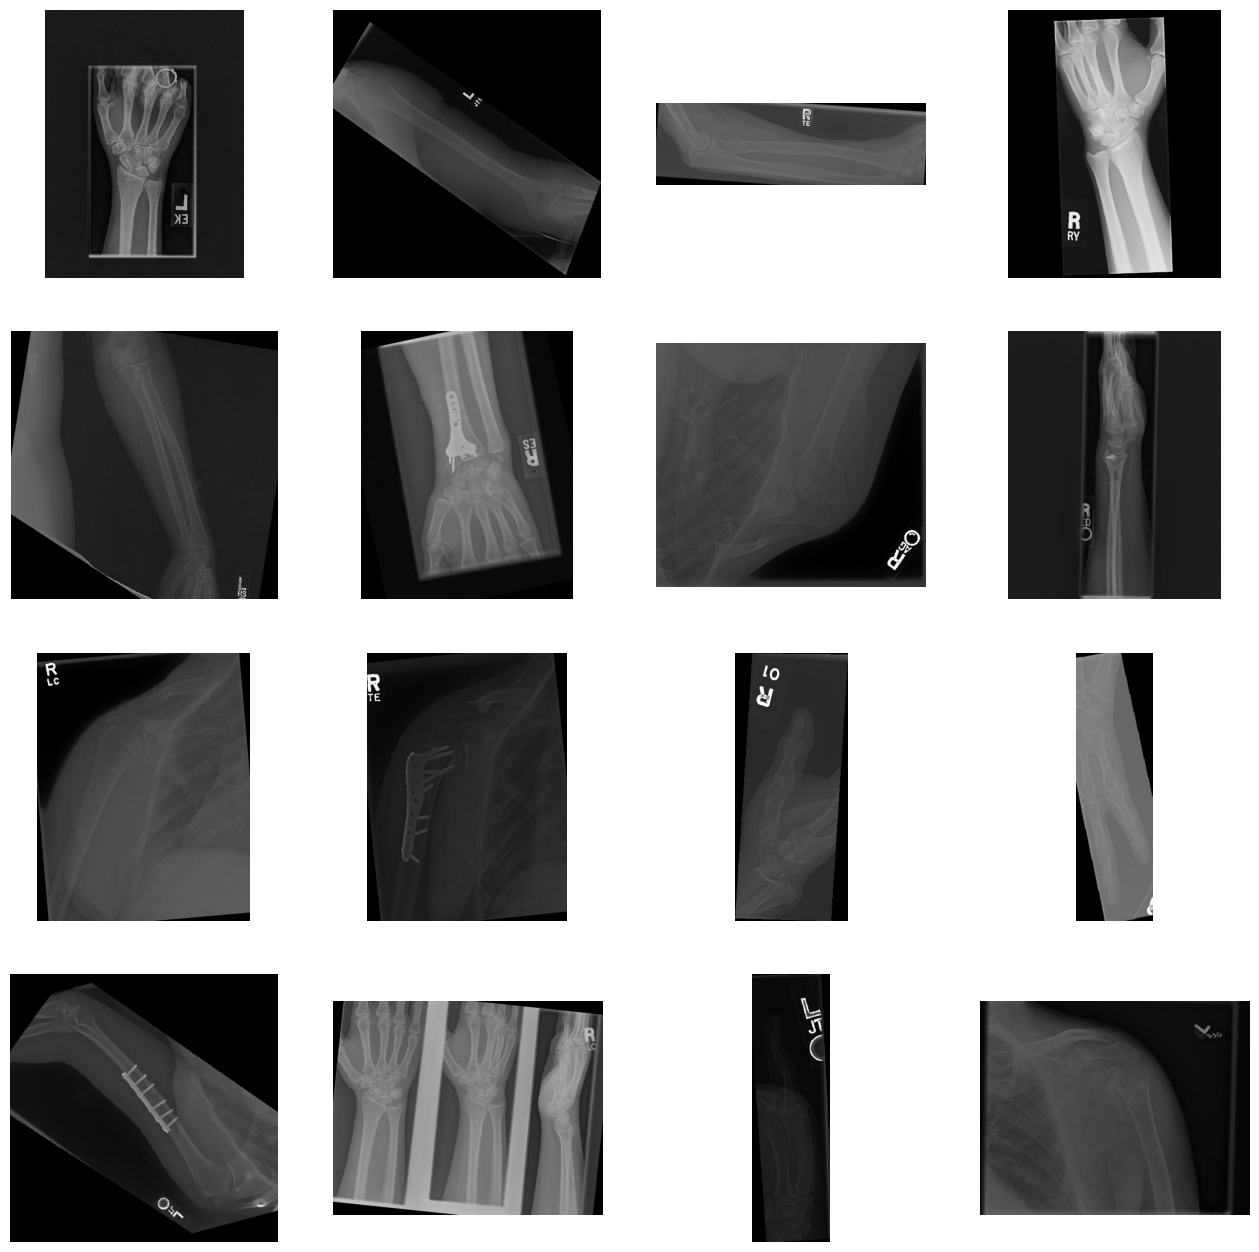

In [12]:
# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

In [13]:
!nvidia-smi --gpu-reset

GPU 00000000:00:04.0 is currently in use by another process.

1 device is currently being used by one or more other processes (e.g., Fabric Manager, CUDA application, graphics application such as an X server, or a monitoring application such as another instance of nvidia-smi). Please first kill all processes using this device and all compute applications running in the system.


In [14]:
# Loading a pretrained model
model = YOLO('yolov8s-obb.pt')

# Training the model
model.train(data = '/content/dataset/data.yaml', task='detect', mode='train', epochs=15, batch=16, seed = 42)

100%|██████████| 22.2M/22.2M [00:01<00:00, 20.3MB/s]


Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=obb, mode=train, model=yolov8s-obb.pt, data=/content/dataset/data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

100%|██████████| 755k/755k [00:00<00:00, 97.7MB/s]


Overriding model.yaml nc=15 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 198MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/train/labels... 3631 images, 1827 backgrounds, 0 corrupt: 100%|██████████| 3631/3631 [00:01<00:00, 1962.43it/s]


train: New cache created: /content/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/valid/labels... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<00:00, 1643.41it/s]

val: New cache created: /content/dataset/valid/labels.cache


Plotting labels to runs/obb/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/obb/train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      9.46G      2.027      6.838      2.548         19       1024: 100%|██████████| 227/227 [03:22<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:10<00:00,  2.10it/s]

                   all        348        204      0.347      0.144      0.156     0.0658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      9.35G      1.858      3.561      2.449         11       1024: 100%|██████████| 227/227 [03:18<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.52it/s]

                   all        348        204      0.223       0.21      0.175     0.0796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15       9.3G      1.843      2.988      2.465         15       1024: 100%|██████████| 227/227 [03:17<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.45it/s]

                   all        348        204      0.497      0.218      0.242      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      9.36G      1.825      2.751       2.47         20       1024: 100%|██████████| 227/227 [03:16<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:09<00:00,  2.37it/s]

                   all        348        204      0.292      0.313      0.256      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15       9.3G      1.732      2.453       2.41         20       1024: 100%|██████████| 227/227 [03:16<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.53it/s]

                   all        348        204      0.415      0.333      0.274      0.131


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      9.32G      1.649       2.21      2.492          8       1024: 100%|██████████| 227/227 [03:11<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.43it/s]

                   all        348        204      0.363      0.327      0.279      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      9.32G      1.581      1.998      2.427          8       1024: 100%|██████████| 227/227 [03:09<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:09<00:00,  2.35it/s]

                   all        348        204      0.358      0.404      0.329      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      9.36G      1.514      1.764      2.363          7       1024: 100%|██████████| 227/227 [03:06<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.47it/s]

                   all        348        204      0.394      0.385       0.33      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      9.29G      1.419      1.525      2.275          8       1024: 100%|██████████| 227/227 [03:11<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.86it/s]

                   all        348        204      0.429      0.345      0.342      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      9.32G      1.378      1.385      2.261          7       1024: 100%|██████████| 227/227 [03:09<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.43it/s]

                   all        348        204      0.406      0.379      0.334      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      9.33G      1.295       1.22      2.158          7       1024: 100%|██████████| 227/227 [03:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.83it/s]

                   all        348        204      0.458      0.354      0.355      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      9.35G      1.235      1.103      2.076         11       1024: 100%|██████████| 227/227 [03:06<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.50it/s]

                   all        348        204      0.448      0.367      0.361      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      9.29G      1.166     0.9879      2.035          6       1024: 100%|██████████| 227/227 [03:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.48it/s]

                   all        348        204       0.36      0.412      0.344      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      9.32G      1.109     0.9107      1.959          8       1024: 100%|██████████| 227/227 [03:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.02it/s]

                   all        348        204      0.458      0.429       0.37      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      9.32G      1.043     0.8095      1.905         11       1024: 100%|██████████| 227/227 [03:12<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.47it/s]

                   all        348        204      0.462       0.42      0.361      0.179



15 epochs completed in 0.840 hours.
Optimizer stripped from runs/obb/train/weights/last.pt, 23.3MB
Optimizer stripped from runs/obb/train/weights/best.pt, 23.3MB

Validating runs/obb/train/weights/best.pt...
Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-obb summary (fused): 187 layers, 11,414,280 parameters, 0 gradients, 29.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:11<00:00,  1.93it/s]


                   all        348        204      0.456      0.429      0.369      0.187
        elbow positive         28         29       0.26      0.207      0.157     0.0544
      fingers positive         41         48      0.339      0.375      0.242      0.105
      forearm fracture         37         43      0.707      0.674      0.689      0.401
               humerus         31         36      0.725      0.694      0.694      0.384
     shoulder fracture         19         20      0.577       0.41      0.364      0.152
        wrist positive         17         28       0.13      0.214     0.0711     0.0234
Speed: 0.5ms preprocess, 9.8ms inference, 0.0ms loss, 11.2ms postprocess per image
Results saved to runs/obb/train


ultralytics.utils.metrics.OBBMetrics object with attributes:

ap_class_index: array([0, 1, 2, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7db920125bd0>
curves: []
curves_results: []
fitness: 0.20487695207328957
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([   0.054353,       0.105,     0.40126,     0.18659,     0.38382,      0.1517,    0.023395])
names: {0: 'elbow positive', 1: 'fingers positive', 2: 'forearm fracture', 3: 'humerus fracture', 4: 'humerus', 5: 'shoulder fracture', 6: 'wrist positive'}
plot: True
results_dict: {'metrics/precision(B)': 0.4563942536190025, 'metrics/recall(B)': 0.42909919284060294, 'metrics/mAP50(B)': 0.3694673554637586, 'metrics/mAP50-95(B)': 0.18658912947434855, 'fitness': 0.20487695207328957}
save_dir: PosixPath('runs/obb/train')
speed: {'preprocess': 0.5171038638586285, 'inference': 9.843488534291586, 'loss': 

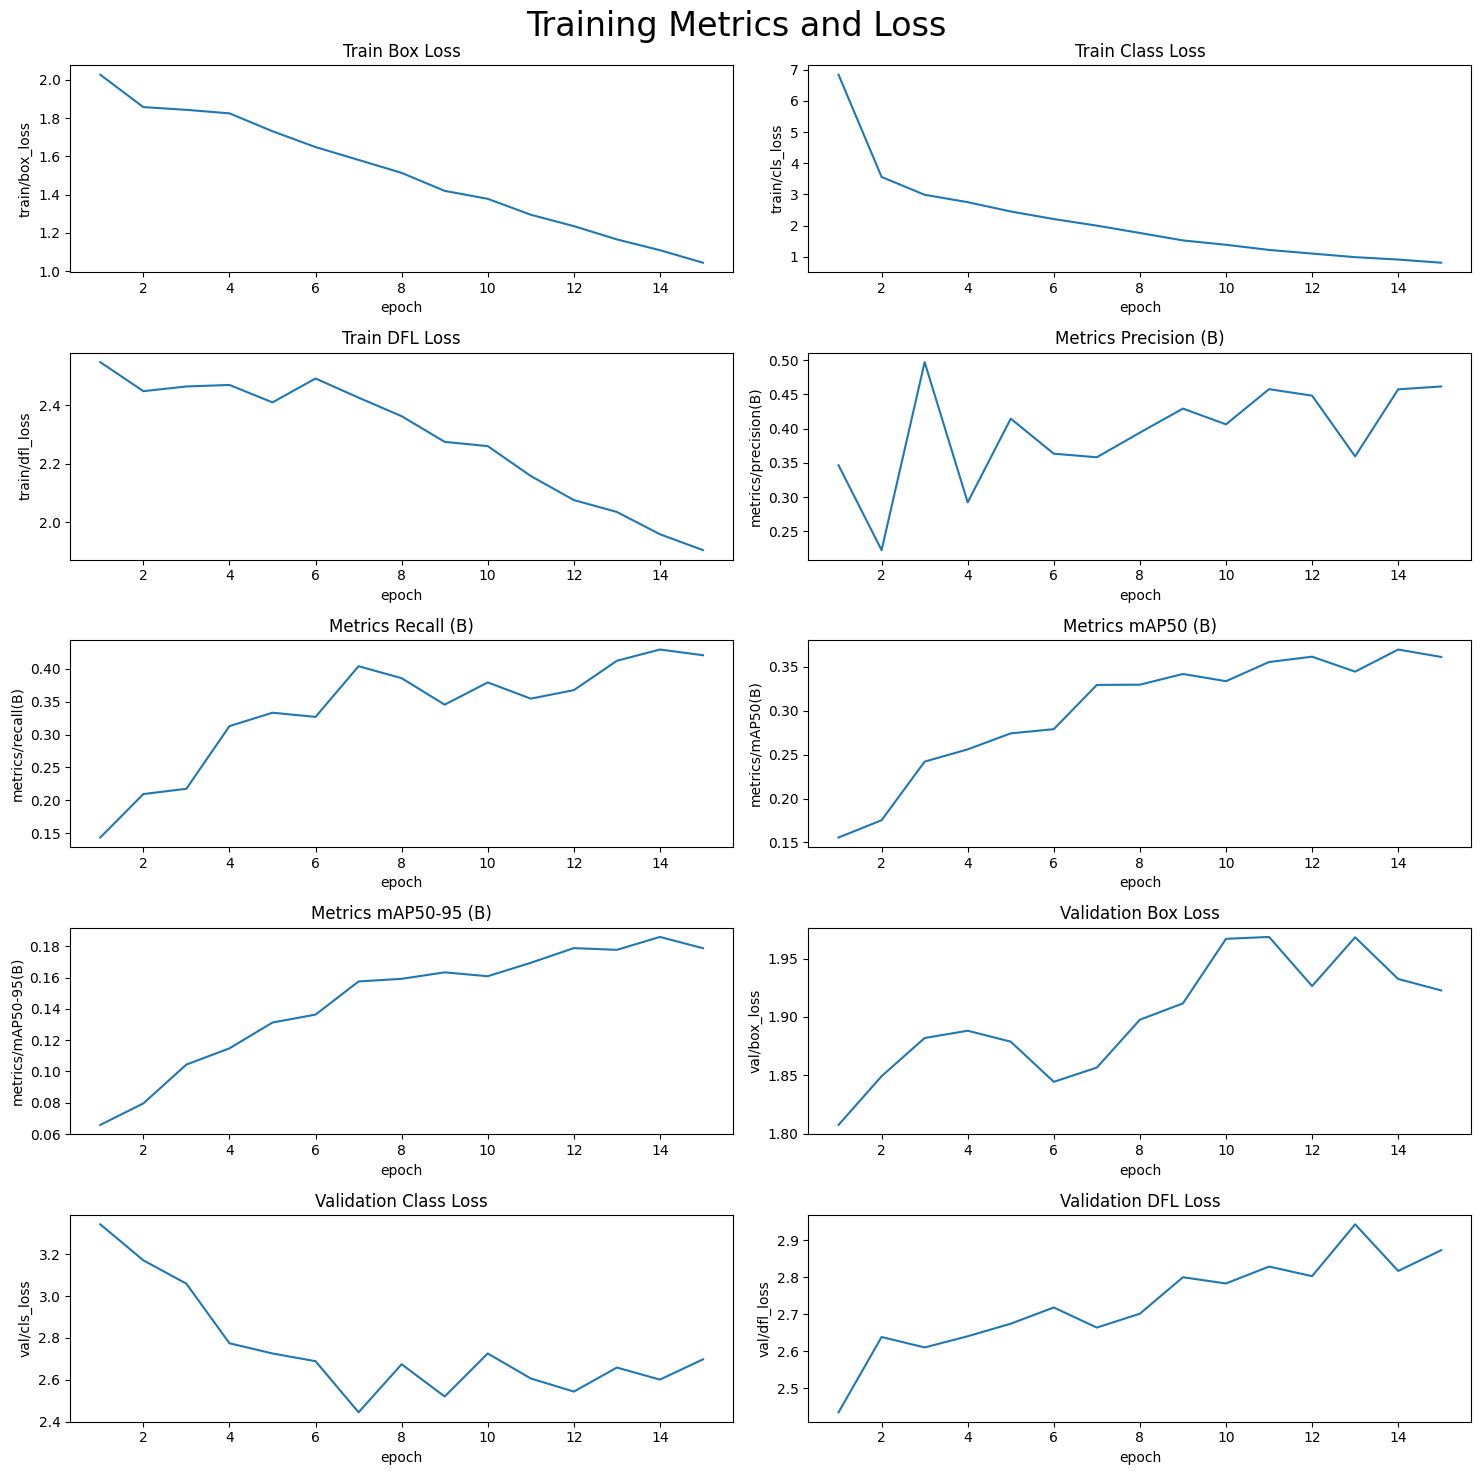

In [16]:
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('runs/obb/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

In [18]:
# Loading the best performing model
model = YOLO('runs/obb/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-obb summary (fused): 187 layers, 11,414,280 parameters, 0 gradients, 29.4 GFLOPs


val: Scanning /content/dataset/test/labels... 169 images, 86 backgrounds, 0 corrupt: 100%|██████████| 169/169 [00:00<00:00, 1283.93it/s]

val: New cache created: /content/dataset/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


                   all        169         96      0.443      0.365      0.404      0.197
        elbow positive         13         17      0.182      0.118      0.119     0.0395
      fingers positive         22         27      0.409      0.333      0.316      0.129
      forearm fracture         13         14      0.818      0.643      0.753      0.423
               humerus         14         15      0.583      0.467      0.531      0.276
     shoulder fracture         15         17      0.556      0.294      0.432      0.197
        wrist positive          6          6      0.111      0.333       0.27      0.119
Speed: 0.8ms preprocess, 27.8ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/obb/val


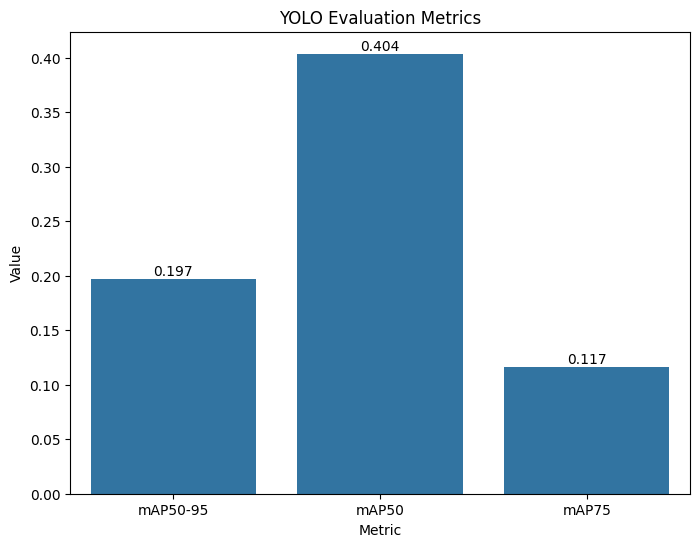

In [19]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

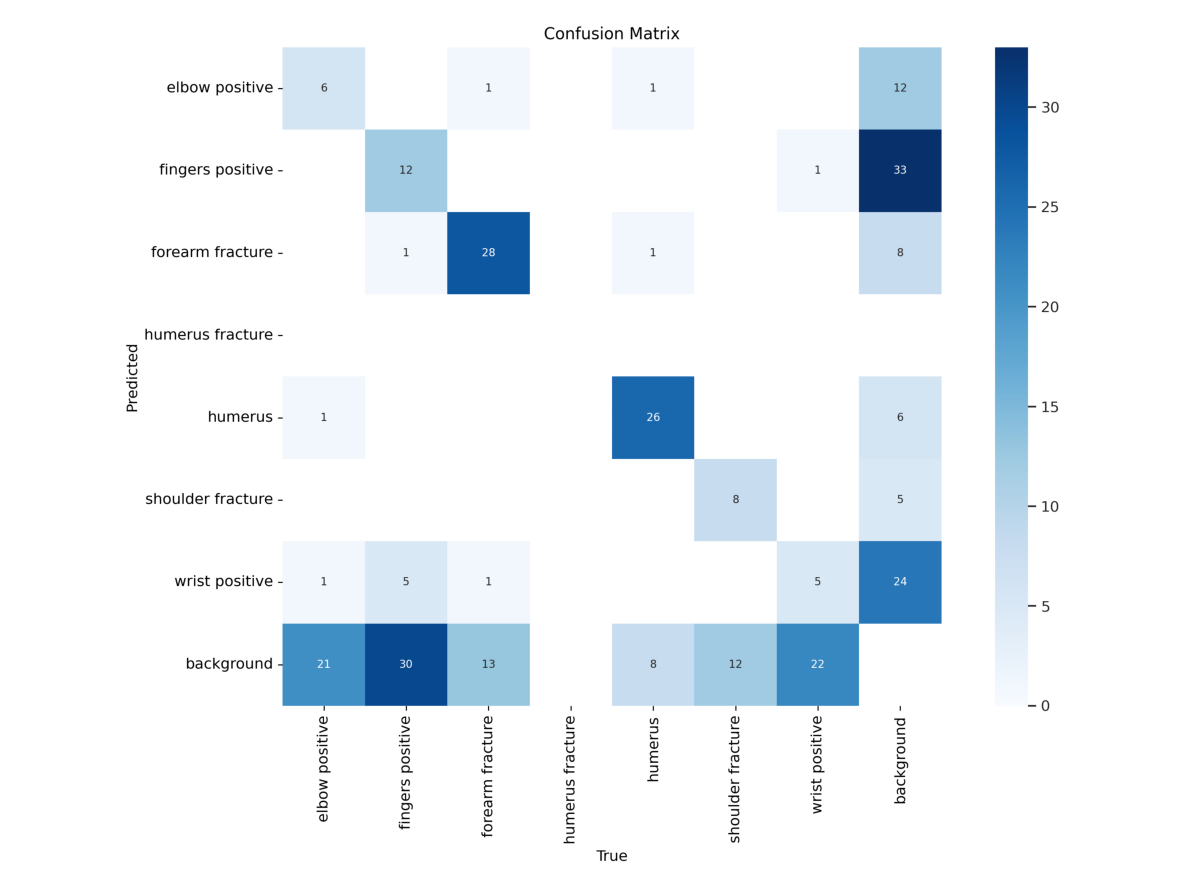

In [20]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('runs/obb/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');